## Import packages

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import scanpy as sc
sc.set_figure_params(dpi=100, dpi_save=300)
import scvi
import anndata as ad
from matplotlib import pyplot, cm
import os
from math import ceil
from scipy.stats import spearmanr
import math
import time
from sciPENN.Preprocessing import preprocess

import leidenalg

from anndata import AnnData
import scanpy as sc
from scanpy import read
import pandas as pd

from read_monocyte_data import read_data

import matplotlib.pyplot as plt
print(scvi.__version__)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


0.10.0


# Read data: Pbmc (train), H1N1 (test)

In [3]:
adata_gene, adata_protein = read_data(cell_normalize = False, log_normalize = False, feature_normalize = False, 
                   dir_path = '../Data/monocytes_mingyao/cite_seq', subset_hvg = False)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

In [4]:
tmp = adata_protein.copy()
sc.pp.normalize_total(tmp)
sc.pp.log1p(tmp)

sums = tmp.X.sum(axis = 0)
samples = ((tmp.X > 0.0001).sum(axis = 0))

expression = sums/samples
adata_protein = adata_protein[:, expression > 0.8].copy()
adata_protein

AnnData object with n_obs × n_vars = 37112 × 113
    obs: 'patient'
    var: 'Common Name', 'expression_type', 'n_counts'
    layers: 'raw'

In [5]:
train_patients = ['RPM211A', 'RPM211B', 'RPM232A', 'RPM232B']
test_patients = ['RPM215A', 'RPM215B', 'RPM218A', 'RPM218B']

train_patientset = [x in train_patients for x in adata_gene.obs['patient']]
test_patientset = [x in test_patients for x in adata_gene.obs['patient']]

adata_gene, adata_gene_test = adata_gene[train_patientset], adata_gene[test_patientset]
adata_protein, adata_protein_test = adata_protein[train_patientset], adata_protein[test_patientset]

# Selecting highly variable genes - using gene expression measures from test data 

In [6]:
gene_train, protein_train, gene_test, bools, train_keys, categories = preprocess([adata_gene], [adata_protein], adata_gene_test, train_batchkeys = ["patient"], test_batchkey = "patient", gene_list = [], select_hvg = True, cell_normalize = True, log_normalize = True, gene_normalize = True, min_cells = 30, min_genes = 200)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.



QC Filtering Training Cells
QC Filtering Testing Cells

QC Filtering Training Genes
QC Filtering Testing Genes

Normalizing Training Cells
Normalizing Testing Cells

Log-Normalizing Training Data
Log-Normalizing Testing Data

Finding HVGs


... storing 'patient' as categorical
... storing 'batch' as categorical
... storing 'Dataset' as categorical
... storing 'expression_type' as categorical
/home/yychen/.conda/envs/scipenn_env/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)



Normalizing Gene Training Data by Batch


100%|██████████| 4/4 [00:00<00:00, 11.22it/s]



Normalizing Protein Training Data by Batch


100%|██████████| 4/4 [00:00<00:00, 37.78it/s]



Normalizing Gene Testing Data by Batch


100%|██████████| 4/4 [00:00<00:00, 12.25it/s]


In [7]:
hvg = gene_test.var_names
cells_test = gene_test.obs_names
cells_train = gene_train.obs_names

In [8]:
del gene_train
del gene_test
del protein_train

import gc
gc.collect()

1566

# Format data

In [9]:
# What proteins overlap between the test and train data?

train_protein = adata_protein.var_names
test_protein = adata_protein_test.var_names
overlap_protein = train_protein[train_protein.isin(test_protein)]

In [10]:
## Subsetting the data by the HVG - pbmc

adata_gene_pbmc_hvg = adata_gene[cells_train, hvg].copy()

In [11]:

## Subsetting the data by the HVG - h1n1

adata_gene_h1n1_hvg = adata_gene_test[cells_test, hvg].copy()

In [12]:
(adata_gene_pbmc_hvg.var.index == adata_gene_h1n1_hvg.var.index).mean()

1.0

In [13]:
adata_protein = adata_protein[cells_train, :].copy()
adata_protein_test = adata_protein_test[cells_test, :].copy()

In [14]:
## Combine data

adata = ad.concat([adata_gene_pbmc_hvg.copy(), adata_gene_h1n1_hvg.copy()],
                     join='outer')

# Subset data based on HVGs and Hold Out Test Protein Set

In [15]:
adata_final = adata.copy()

In [16]:
held_out_proteins = adata_protein_test[cells_test, overlap_protein].copy()

### Now we hold-out the proteins for the test patients dataset. To do so, we can replace all the values with 0s. We will store the original values to validate after training.

In [17]:
# Modified this code cell to predict all p = 224 proteins

n, p = adata_protein.shape
n_test, p_test = adata_protein_test.shape

protein_dat = pd.DataFrame(np.zeros(shape = (n + n_test, p), dtype = 'float32'), 
                           index = list(adata_protein.obs_names) + list(adata_protein_test.obs_names),
                           columns = adata_protein.var_names)

protein_dat.iloc[:n] = adata_protein.X.copy() #fill the protein training data, leave test data as 0s

adata_final.obsm["protein_expression"] = protein_dat

# Remove additional data from memory:

In [18]:
del adata_gene
del adata_protein
del adata_protein_test
del adata_gene_test
del adata_gene_pbmc_hvg
del adata

# Run TotalVI

In [19]:
scvi.data.setup_anndata(adata_final, batch_key="patient", 
                        protein_expression_obsm_key="protein_expression")

INFO     Using batches from adata.obs["patient"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_expression']                      
INFO     Using protein names from columns of adata.obsm['protein_expression']                
INFO     Found batches with missing protein expression                                       
INFO     Successfully registered anndata object containing 37018 cells, 1000 vars, 8 batches,
         1 labels, and 113 proteins. Also registered 0 extra categorical covariates and 0    
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is t

In [20]:
scvi.data.view_anndata_setup(adata_final)

Anndata setup with scvi-tools version 0.10.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 37018 │
│             Vars             │ 1000  │
│            Labels            │   1   │
│           Batches            │   8   │
│           Proteins           │  113  │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                   SCVI Data Registry                    
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Data        ┃       scvi-tools Location        ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         X          │             adata.X              │
│   batch_indices    │     adata.obs['_scvi_batch']     │
│    local_l_mean    │ adata.obs['_scvi_local_l_mean']  │
│    local_l_var     │  adata.obs['_scvi_local_l_var']  │
│       labels       │    adata.obs['_scvi_labels']     │
│ protein_expression │ adata.obsm['protein_expression'] │
└────────────────────┴──────────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     Batch Categories                      
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient'] │  RPM211A   │          0          │
│                      │  RPM211B   │          1          │
│                      │  RPM215A   │          2          │
│                      │  RPM215B   │          3          │
│                      │  RPM218A   │          4          │
│                      │  RPM218B   │          5          │
│                      │  RPM232A   │          6          │
│                      │  RPM232B   │          7          │
└──────────────────────┴────────────┴─────────────────────┘

In [21]:
totalvae = scvi.model.TOTALVI(
    adata_final,
    latent_distribution = "normal",
    n_layers_decoder = 2)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:  -0%|          | -1/400 [00:00<?, ?it/s]

/home/yychen/.conda/envs/scipenn_env/lib/python3.7/site-packages/tqdm/std.py:538: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
/home/yychen/.conda/envs/scipenn_env/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:406: LightningDeprecationWarning: One of the returned values {'kl_global', 'reconstruction_loss_sum', 'n_obs', 'kl_local_sum'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Epoch 2/400:   0%|          | 0/400 [00:10<1:08:25, 10.26s/it, loss=264, v_num=1]

/home/yychen/.conda/envs/scipenn_env/lib/python3.7/site-packages/pytorch_lightning/trainer/callback_hook.py:103: LightningDeprecationWarning: The signature of `Callback.on_train_epoch_end` has changed in v1.3. `outputs` parameter has been removed. Support for the old signature will be removed in v1.5
  "The signature of `Callback.on_train_epoch_end` has changed in v1.3."


Epoch 340/400:  85%|████████▍ | 339/400 [55:38<09:58,  9.82s/it, loss=272, v_num=1]


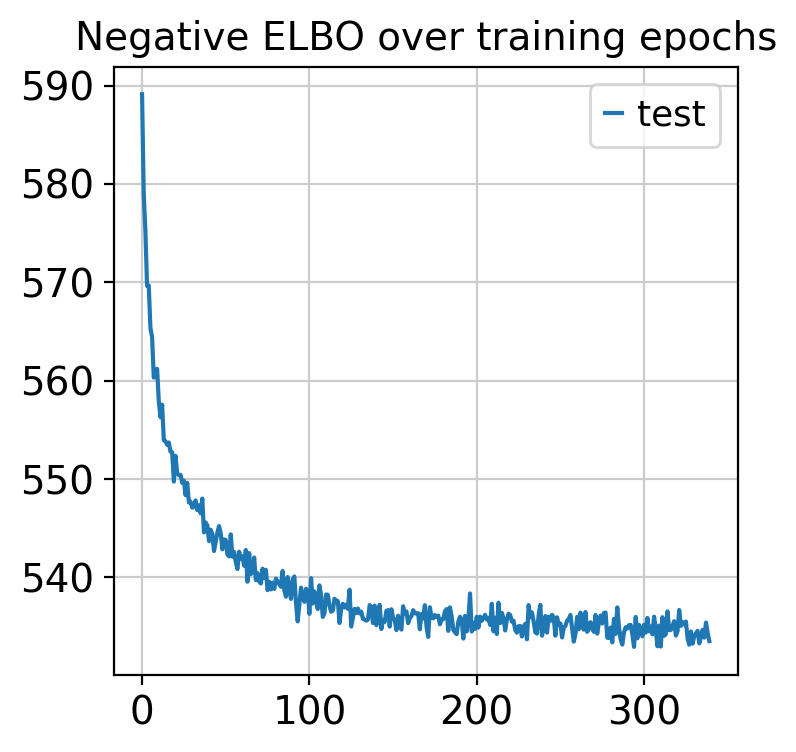

In [23]:
n_epochs = 400
lr = 4e-3

if os.path.isdir('weights_dir/totalvi_monocyte_to_monocyte'):
    totalvae = totalvae.load("weights_dir/totalvi_monocyte_to_monocyte", adata = adata_final)
else:
    totalvae.train(max_epochs=400)
    plt.plot(totalvae.history["elbo_validation"], label="test")
    plt.title("Negative ELBO over training epochs")
    plt.legend()
    
    totalvae.save("weights_dir/totalvi_monocyte_to_monocyte")

# Analyze output - Results on training data

In [24]:
_, protein_means = totalvae.get_normalized_expression(
    transform_batch=train_patients,
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

#### Note that: transform_batch is a power parameter. Setting this allows one to predict the expression of cells as if they came from the inputted batch. In this case, we’ve observed protein expression in the training batchs “RPM211 and RPM232” (batch categories from original adata object), but we have no protein expression in the test batchs “RPM215 and RPM218”. We’d like to take the cells of the trainig batch and make a counterfactual prediction: “What would the expression look like if my batch "RPM211 and RPM232" cells came from batch “RPM215 and RPM218”?”

In [25]:
X_totalVI = pd.DataFrame(totalvae.get_latent_representation(), index = adata_final.obs.index)
X_totalVI.to_csv("totalvi_monocyteembedding.csv")

# Imputed protein expression: 

In [26]:
true_protein_test = pd.DataFrame(held_out_proteins.X, index = held_out_proteins.obs.index, columns = held_out_proteins.var.index)

In [27]:
imputed_proteins_test = protein_means[adata_final.obs.patient.isin(test_patients)]

pat_names = adata_final.obs['patient'].isin(test_patients)
patients = adata_final.obs.patient[pat_names].values
# imputed_proteins_test = imputed_pros[overlap_protein] # Subset totalvi output to only include overlapping proteins

In [28]:
def corr2_coeff(A, B, pearson = True):
    if pearson:
        # Rowwise mean of input arrays & subtract from input arrays themeselves
        A_mA = A - A.mean(1)[:, None]
        B_mB = B - B.mean(1)[:, None]

        # Sum of squares across rows
        ssA = (A_mA**2).sum(1)
        ssB = (B_mB**2).sum(1)

        # Finally get corr coeff
        corr_mat = np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))
        
        return corr_mat[range(corr_mat.shape[0]), range(corr_mat.shape[0])]
    
    else:
        corrs = [0.] * A.shape[0]
        
        for i in range(A.shape[0]):
            corrs[i] = spearmanr(A[i], B[i])[0]
            
        return corrs

In [29]:
cells, proteins = imputed_proteins_test.index, imputed_proteins_test.columns

In [30]:
# Normalize totalvi output, and gold standard counts

true_protein_test = AnnData(true_protein_test)
imputed_proteins_test = AnnData(imputed_proteins_test)

sc.pp.normalize_total(true_protein_test)
sc.pp.log1p(true_protein_test)

sc.pp.normalize_total(imputed_proteins_test)
sc.pp.log1p(imputed_proteins_test)

for patient in test_patients:
    indices = [x == patient for x in patients]
    sub_adata = imputed_proteins_test[indices]
    sc.pp.scale(sub_adata)
    imputed_proteins_test[indices] = sub_adata.X
    
    sub_adata = true_protein_test[indices]
    sc.pp.scale(sub_adata)
    true_protein_test[indices] = sub_adata.X

true_protein_test = pd.DataFrame(true_protein_test.X, index = cells, columns = proteins)
imputed_proteins_test = pd.DataFrame(imputed_proteins_test[:, overlap_protein].X, index = cells, columns = proteins)

/home/yychen/.conda/envs/scipenn_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [31]:
sq = lambda x, y: (x - y)**2

In [32]:
corrs_table = np.zeros((imputed_proteins_test.shape[1], len(np.unique(patients))))
sq_table = corrs_table.copy()

for i, patient in enumerate(np.unique(patients)):
    truth = true_protein_test[patients == patient].to_numpy()
    imputed = imputed_proteins_test[patients == patient].to_numpy()

    corrs_table[:, i] = corr2_coeff(truth.T, imputed.T)
    sq_table[:, i] = sq(truth, imputed).mean(axis = 0)
    
if np.isnan(corrs_table).sum() > 0:
    corrs_table[np.isnan(corrs_table)] = 0
    
corrs_table = pd.DataFrame(corrs_table)
sq_table = pd.DataFrame(sq_table)

corrs_table.index, corrs_table.columns = imputed_proteins_test.columns, np.unique(patients)
sq_table.index, sq_table.columns = imputed_proteins_test.columns, np.unique(patients)

In [33]:
#here are correlations

corrs_table.mean()

RPM215A    0.335635
RPM215B    0.504905
RPM218A    0.355093
RPM218B    0.465350
dtype: float64

In [34]:
#here are correlations

corrs_table.mean().mean()

0.41524564016989507

In [35]:
corrs_table.to_csv('corrs_results/totalvi_monocyte.csv')

In [36]:
sq_table.mean(axis = 0)

RPM215A    1.328436
RPM215B    0.989997
RPM218A    1.289484
RPM218B    1.069031
dtype: float64

In [37]:
sq_table.mean().mean()

1.169236657662993

In [38]:
sq_table.to_csv('mse_results/totalvi_monocyte.csv')

In [39]:
imputed_proteins_test.to_csv('totalvi_monocytefeatures.csv')

In [40]:
# Create empty vectors to store percentiles

q10 = np.empty(shape = true_protein_test.shape)
q90 = np.empty(shape = true_protein_test.shape)
q25 = np.empty(shape = true_protein_test.shape)
q75 = np.empty(shape = true_protein_test.shape)


pat_names = adata_final.obs['patient'].isin(test_patients)
patients = adata_final.obs.patient[pat_names].values

In [41]:
class generator:
    def __init__(self, test_idx, batch_size, seed = 123):
        self.test_idx = test_idx
        self.batch_size = batch_size
        self.seed = seed
        
    def __iter__(self):
        np.random.seed(self.seed)
        idx = np.random.choice(range(len(self.test_idx)), len(self.test_idx), False)
        
        batch, test_batch = [], []
        
        for index in idx:
            batch.append(index)
            test_batch.append(self.test_idx[index])
            
            if len(batch) == self.batch_size:
                yield batch, test_batch
                batch, test_batch = [], []
                
        if batch:
            yield batch, test_batch
    
    def get(self):
        return self

In [42]:
base_path = 'totalVI_quantiles_monocyte'

if not os.path.isdir(base_path):
    os.mkdir(base_path)

In [43]:
if all([os.path.isfile(os.path.join(base_path, path)) for path in ('q10.csv', 'q25.csv', 'q75.csv', 'q90.csv')]):
    q10 = pd.read_csv(os.path.join(base_path, 'q10.csv'), index_col = 0)
    q25 = pd.read_csv(os.path.join(base_path, 'q25.csv'), index_col = 0)
    q75 = pd.read_csv(os.path.join(base_path, 'q75.csv'), index_col = 0)
    q90 = pd.read_csv(os.path.join(base_path, 'q90.csv'), index_col = 0)
    
else:    
    for idx, test_idx in generator(list(range(n, n + n_test)), 5000).get(): 
        start_time = time.time()

        ######################################################
        # (1) sequentially sample 5000 from the test index #
        #####################################################

        _, protein_means_samples = totalvae.get_normalized_expression(
            transform_batch=train_patients,
            n_samples=1000,
            include_protein_background=True,
            sample_protein_mixing=False,
            return_mean = False,
            indices = test_idx,
        )

        # Subset to overlapping proteins for evaluations

        # index of overlaping_proteins
        name_map = {protein: i for i, protein in enumerate(imputed_proteins_test.columns)}
        index_overlap = [name_map[protein] for protein in overlap_protein]
        # (2) normalize and scale samples #
        ###################################

        # normalize totalvi sample output
        sf = protein_means_samples.sum(axis = 1)
        sf = np.median(sf, axis = 0)[None, :]/sf

        protein_means_samples_norm = protein_means_samples * sf[:, None, :]
        protein_means_samples_norm = np.log(protein_means_samples_norm + 1)
        protein_means_samples_norm = protein_means_samples_norm[:, index_overlap]
        
        patient_indices = patients[idx]
        for patient in test_patients:
            indices = [x == patient for x in patient_indices]
            sub_data = protein_means_samples_norm[indices]
            mean, sd = sub_data.mean(axis = 0), sub_data.std(axis = 0)
            sub_data = (sub_data - mean)/sd
            protein_means_samples_norm[indices] = sub_data

        #########################################################
        # (3) calculate percentiles 0.10, 0.90, 0.25, and 0.75 #
        ########################################################

        q10[idx] = np.percentile(protein_means_samples_norm, 10, axis = 2)
        q90[idx] = np.percentile(protein_means_samples_norm, 90, axis = 2)
        q25[idx] = np.percentile(protein_means_samples_norm, 25, axis = 2)
        q75[idx] = np.percentile(protein_means_samples_norm, 75, axis = 2)


        ##################################
        # (4) remove samples from memory #
        ###################################

        del protein_means_samples
        del protein_means_samples_norm

        end_time = time.time()

        print("Run time for loop: --- %s seconds ---" % (end_time - start_time)) #

    cols = imputed_proteins_test[overlap_protein].columns
    names = imputed_proteins_test[overlap_protein].index
    q10 = pd.DataFrame(q10, columns=cols, index = adata_final.obs.index[n:])
    q90 = pd.DataFrame(q90, columns=cols, index = adata_final.obs.index[n:])
    q25 = pd.DataFrame(q25, columns=cols, index = adata_final.obs.index[n:])
    q75 = pd.DataFrame(q75, columns=cols, index = adata_final.obs.index[n:])

    q10.to_csv(os.path.join(base_path, 'q10.csv'))
    q25.to_csv(os.path.join(base_path, 'q25.csv'))
    q75.to_csv(os.path.join(base_path, 'q75.csv'))
    q90.to_csv(os.path.join(base_path, 'q90.csv'))

Run time for loop: --- 299.84493136405945 seconds ---
Run time for loop: --- 301.9956533908844 seconds ---
Run time for loop: --- 300.3656852245331 seconds ---
Run time for loop: --- 147.56454992294312 seconds ---


In [44]:
true_protein_test.to_csv(os.path.join(base_path, "truth.csv"))

In [45]:
r50 = (true_protein_test < q75)
l50 = (true_protein_test > q25)

print(f"Effective Coverage Probability for Nominal 50% PIs: {(r50*l50).mean()}")
print(f"Mean effective Coverage Probability for Nominal 50% PI: {(r50*l50).mean().mean()}")

Effective Coverage Probability for Nominal 50% PIs: CD44                   0.126891
CD11a                  0.089674
CD48                   0.127233
Beta2-microglobulin    0.156972
CD162                  0.090302
                         ...   
CD303                  0.092357
CD110                  0.122496
CCR10                  0.042126
CD271                  0.079057
CD74                   0.115532
Length: 113, dtype: float64
Mean effective Coverage Probability for Nominal 50% PI: 0.11395668015560351


/home/yychen/.conda/envs/scipenn_env/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [46]:
lengths = np.subtract(q75,q25)
print(f"Mean 50% interval lengths: {lengths.mean()}")
print(f"Overall mean 50% interval length: {lengths.mean().mean()}")

Mean 50% interval lengths: CD44                   0.382297
CD11a                  0.251717
CD48                   0.365908
Beta2-microglobulin    0.498369
CD162                  0.182654
                         ...   
CD303                  0.235346
CD110                  0.448270
CCR10                  0.075722
CD271                  0.161213
CD74                   0.229986
Length: 113, dtype: float64
Overall mean 50% interval length: 0.2941462627704532


In [47]:
r80 = (true_protein_test < q90)
l80 = (true_protein_test > q10)

print(f"Effective Coverage Probability for Nominal 80% PIs: {(r80*l80).mean()}")
print(f"Mean effective Coverage Probability for Nominal 80% PI: {(r80*l80).mean().mean()}")

Effective Coverage Probability for Nominal 80% PIs: CD44                   0.241738
CD11a                  0.165592
CD48                   0.234945
Beta2-microglobulin    0.293967
CD162                  0.170558
                         ...   
CD303                  0.171756
CD110                  0.236829
CCR10                  0.080484
CD271                  0.152863
CD74                   0.218905
Length: 113, dtype: float64
Mean effective Coverage Probability for Nominal 80% PI: 0.21530000045462652


/home/yychen/.conda/envs/scipenn_env/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [48]:
lengths = np.subtract(q90,q10)
print(f"Mean 80% interval lengths: {lengths.mean()}")
print(f"Overall mean 80% interval length: {lengths.mean().mean()}")

Mean 80% interval lengths: CD44                   0.726809
CD11a                  0.479269
CD48                   0.695636
Beta2-microglobulin    0.947360
CD162                  0.347606
                         ...   
CD303                  0.449352
CD110                  0.851716
CCR10                  0.145231
CD271                  0.306985
CD74                   0.436726
Length: 113, dtype: float64
Overall mean 80% interval length: 0.5595668160507261


## Double checking intervals using the protein mean estimates from totalVI

In [49]:
imputed_proteins_test.columns = overlap_protein
r50 = (imputed_proteins_test < q75)
l50 = (imputed_proteins_test > q25)

print((r50*l50).mean())
print(f"Effective Coverage Probability for Nominal 50% PI: {(r50*l50).mean().mean()}")

CD44                   0.494206
CD11a                  0.492151
CD48                   0.491181
Beta2-microglobulin    0.503453
CD162                  0.488213
                         ...   
CD303                  0.486900
CD110                  0.496946
CCR10                  0.443918
CD271                  0.487927
CD74                   0.485872
Length: 113, dtype: float64
Effective Coverage Probability for Nominal 50% PI: 0.48879219375979654


/home/yychen/.conda/envs/scipenn_env/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [50]:
r80 = (imputed_proteins_test < q90)
l80 = (imputed_proteins_test > q10)

print((r80*l80).mean())
print(f"Effective Coverage Probability for Nominal 80% PI: {(r80*l80).mean().mean()}")

CD44                   0.792625
CD11a                  0.790570
CD48                   0.788401
Beta2-microglobulin    0.804840
CD162                  0.788287
                         ...   
CD303                  0.781494
CD110                  0.791255
CCR10                  0.729950
CD271                  0.787374
CD74                   0.784348
Length: 113, dtype: float64
Effective Coverage Probability for Nominal 80% PI: 0.7867796632429923


/home/yychen/.conda/envs/scipenn_env/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
